In [2]:
import sys
import os
sys.path.append(os.path.abspath(".."))
from edmAnalyzer import *
from IPython.display import clear_output
import pickle

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import plotly.express as px
from scipy.optimize import curve_fit


# Doppler Scan Analysis Pipeline

In [3]:
run = 10
sequence = 1869
traceoffset = 31
traceperblock = 32
cutoff = 10
degeneracy = ["D"]
number_of_block_per_degeneracy = None
quantity_of_interest = ['Delta_TiSapph']
parity_transform =  ["P"]

In [4]:
a = runHandler()
a.new_pipeline(name = "doppler", run = run, sequence = sequence, sequence_type = None, bincut = cutoff, binpara = traceoffset, blockcut = None, blockpara = None, config = None)
a.calculate_bin_result()
a.cut_bin()
clear_output(wait=False)

In [5]:
import os
import pickle
import pandas as pd
import numpy as np

# Assume 'a' contains path_df, df, and run_folder
folder_path = a.path_df["binresult_data_folder_path"][0]
df = a.df.copy()

# Dictionary to store new column names
new_columns = {
    "Fx_sipm": [],
    "Fy_sipm": [],
    "N_sipm": [],
    "A_sipm": [],
    "aggregated": ["Fx_sipmavg", "Fy_sipmavg", "N_sipmavg", "A_sipmavg"]
}

# Identify unique (run, sequence, block) in folder
file_list = os.listdir(folder_path)
identifiers = set()

for filename in file_list:
    if filename.startswith("binresult_") and filename.endswith(".pkl"):
        parts = filename[len("binresult_"):-len(".pkl")].split(".")
        if len(parts) == 4:
            run, sequence, block, trace = map(int, parts)
            identifiers.add((run, sequence, block))

# Helper function to slice and reduce matrices
def reduce_matrix(matrix, is_weighted=False, weight_matrix=None, left=None, right=None):
    sliced = matrix[:, :, :, left:right]
    if is_weighted:
        weight_sliced = weight_matrix[:, :, :, left:right]
        weighted = sliced * weight_sliced
        summed = weighted.sum(axis=1).sum(axis=-1)
        normalizer = weight_sliced.sum(axis=1).sum(axis=-1)
        result = summed / np.maximum(normalizer, 1e-10)
    else:
        result = sliced.sum(axis=1).sum(axis=-1)
    return result

# Process each group of binresult/bincutresult pairs
for run, sequence, block in identifiers:
    binresult_path = os.path.join(
        folder_path, f"binresult_{str(run).zfill(4)}.{str(sequence).zfill(4)}.{str(block).zfill(4)}.0000.pkl"
    )
    bincutresult_path = os.path.join(
        folder_path, f"bincutresult_{str(run).zfill(4)}.{str(sequence).zfill(4)}.{str(block).zfill(4)}.0000.pkl"
    )

    with open(binresult_path, 'rb') as f:
        binresult = pickle.load(f)
    with open(bincutresult_path, 'rb') as f:
        bincutresult = pickle.load(f)

    left, right = bincutresult.grand_left, bincutresult.grand_right

    Fx = reduce_matrix(binresult.Fx, left=left, right=right)
    Fy = reduce_matrix(binresult.Fy, left=left, right=right)
    N = reduce_matrix(binresult.N, left=left, right=right)
    A = reduce_matrix(binresult.A, is_weighted=True, weight_matrix=binresult.N, left=left, right=right)

    traces = Fx.shape[0]
    sipms = Fx.shape[1]

    for trace_idx in range(traces):
        match_idx = (
            (df['run'] == run) &
            (df['sequence'] == sequence) &
            (df['block'] == block) &
            (df['trace'] == trace_idx)
        )
        for sipm_idx in range(sipms):
            fx_col = f"Fx_sipm{sipm_idx}"
            fy_col = f"Fy_sipm{sipm_idx}"
            n_col = f"N_sipm{sipm_idx}"
            a_col = f"A_sipm{sipm_idx}"

            df.loc[match_idx, fx_col] = Fx[trace_idx, sipm_idx]
            df.loc[match_idx, fy_col] = Fy[trace_idx, sipm_idx]
            df.loc[match_idx, n_col] = N[trace_idx, sipm_idx]
            df.loc[match_idx, a_col] = A[trace_idx, sipm_idx]

            if fx_col not in new_columns["Fx_sipm"]:
                new_columns["Fx_sipm"].append(fx_col)
            if fy_col not in new_columns["Fy_sipm"]:
                new_columns["Fy_sipm"].append(fy_col)
            if n_col not in new_columns["N_sipm"]:
                new_columns["N_sipm"].append(n_col)
            if a_col not in new_columns["A_sipm"]:
                new_columns["A_sipm"].append(a_col)

        df.loc[match_idx, "Fx_sipmavg"] = Fx[trace_idx].sum()
        df.loc[match_idx, "Fy_sipmavg"] = Fy[trace_idx].sum()
        df.loc[match_idx, "N_sipmavg"] = N[trace_idx].sum()
        a_weighted_avg = (A[trace_idx] * N[trace_idx]).sum() / np.maximum(N[trace_idx].sum(), 1e-10)
        df.loc[match_idx, "A_sipmavg"] = a_weighted_avg

# Save result
output_path = os.path.join(a.run_folder, "doppler_result.csv")
df.to_csv(output_path, index=False)


In [6]:
df = pd.read_csv(output_path)

In [7]:
df_slice = df[(df["D"] == -1) & (df["P"] == 1)]
plt.plot(df_slice["Delta_TiSapph"], df_slice["Fx_sipm2"], "o")

df_slice = df[(df["D"] == -1) & (df["P"] == -1)]
plt.plot(df_slice["Delta_TiSapph"], df_slice["Fx_sipm2"], "o")

KeyError: 'D'

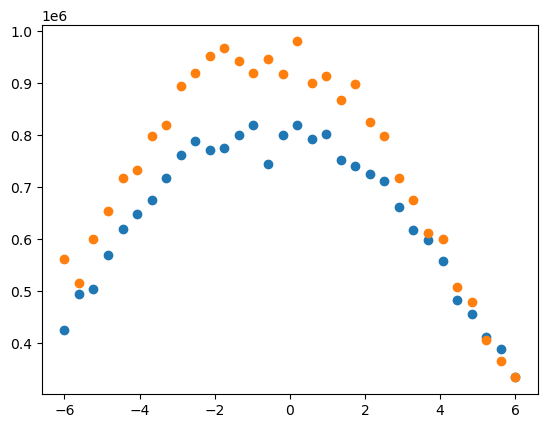

In [ ]:
sipm = 3
df_slice = df[(df["D"] == 1) & (df["P"] == 1)]
plt.plot(df_slice["Delta_TiSapph"], df_slice["Fx_sipm"+ str(sipm)], "o")

df_slice = df[(df["D"] == 1) & (df["P"] == -1)]
plt.plot(df_slice["Delta_TiSapph"], df_slice["Fx_sipm"+ str(sipm)], "o")

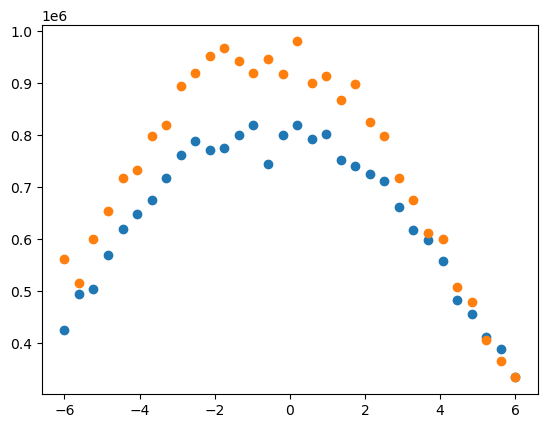

In [ ]:
sipm = 3
df_slice = df[(df["D"] == 1) & (df["P"] == 1)]
plt.plot(df_slice["Delta_TiSapph"], df_slice["Fx_sipm"+ str(sipm)], "o")

df_slice = df[(df["D"] == 1) & (df["P"] == -1)]
plt.plot(df_slice["Delta_TiSapph"], df_slice["Fx_sipm"+ str(sipm)], "o")

In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

# Gaussian function
def gaussian(x, amp, mu, sigma):
    return amp * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

# Smart initial guess
def initial_guess(x, y):
    amp_guess = np.nanmax(y)
    mu_guess = x[np.nanargmax(y)]
    sigma_guess = np.nanstd(x)
    return amp_guess, mu_guess, sigma_guess

# Flatten new_columns dict
flat_columns = []
for group in new_columns.values():
    flat_columns.extend(group)

# Storage for the fitted results
fitted_results = []

# Process by parity_transform group
for parity_keys, parity_group in df.groupby(parity_transform):
    # Convert to dict if single key
    if not isinstance(parity_keys, tuple):
        parity_keys = (parity_keys,)

    record = dict(zip(parity_transform, parity_keys))

    # Group by degeneracy
    subresults = {col: {"loc": [], "scale": [], "amp": []} for col in flat_columns}

    for _, degeneracy_group in parity_group.groupby(degeneracy):
        for col in flat_columns:
            x = degeneracy_group[quantity_of_interest[0]].values
            y = degeneracy_group[col].values

            # Drop NaNs
            valid = ~(np.isnan(x) | np.isnan(y))
            x_clean = x[valid]
            y_clean = y[valid]

            if len(x_clean) < 3:
                continue  # Not enough points to fit

            try:
                popt, _ = curve_fit(gaussian, x_clean, y_clean, p0=initial_guess(x_clean, y_clean))
                amp, mu, sigma = popt
                subresults[col]["amp"].append(amp)
                subresults[col]["loc"].append(mu)
                subresults[col]["scale"].append(np.abs(sigma))  # sigma should be positive
            except RuntimeError:
                continue  # Fit failed

    # Average across degeneracy
    for col in flat_columns:
        for param in ["amp", "loc", "scale"]:
            values = subresults[col][param]
            record[f"{col}_{param}"] = np.mean(values) if values else np.nan

    fitted_results.append(record)

# Convert to DataFrame
output_fitted_path = os.path.join(a.run_folder, "doppler_fitted_result.csv")
fitted_df = pd.DataFrame(fitted_results)
fitted_df.to_csv(output_fitted_path, index=False)


c:\Users\ACME\anaconda3\envs\physenv\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_gaussian_summary(fitted_df, parity_transform):
    sipm_range = range(8)
    quantity_pairs = [('Fx', 'blue'), ('Fy', 'red')]
    x_vals = np.linspace(-5, 5, 500)

    # Replace missing parity_transform columns with dummy values
    for col in parity_transform:
        if col not in fitted_df.columns:
            fitted_df[col] = 'N/A'

    # Get unique combinations of parity_transform values
    parity_keys = fitted_df[parity_transform].drop_duplicates().to_dict(orient='records')

    fig, axes = plt.subplots(len(parity_keys), len(sipm_range),
                             figsize=(24, 3 * len(parity_keys)), sharex=True, sharey=True)

    if len(parity_keys) == 1:
        axes = np.array([axes])
    elif len(sipm_range) == 1:
        axes = axes.reshape((len(parity_keys), 1))

    for i, key_vals in enumerate(parity_keys):
        # Create mask for this parity group
        mask = np.ones(len(fitted_df), dtype=bool)
        for col, val in key_vals.items():
            mask &= (fitted_df[col] == val)
        group = fitted_df[mask]

        for k in sipm_range:
            ax = axes[i, k]
            for q, color in quantity_pairs:
                loc_col = f"{q}_sipm{k}_loc"
                scale_col = f"{q}_sipm{k}_scale"
                if loc_col in group.columns and scale_col in group.columns:
                    locs = group[loc_col].dropna()
                    scales = group[scale_col].dropna()
                    if not locs.empty and not scales.empty:
                        mean_loc = locs.mean()
                        mean_scale = scales.mean()
                        gauss = np.exp(-0.5 * ((x_vals - mean_loc) / mean_scale) ** 2)
                        ax.plot(x_vals, gauss, label=q, color=color)
                        ax.axvline(mean_loc, linestyle='--', color=color)

            title = f"SIPM {k} | " + ", ".join([f"{k}={v}" for k, v in key_vals.items()])
            ax.set_title(title)
            ax.grid(True)

    # Calculate and annotate X^P, Y^P, XY for each sipm
    if "P" in parity_transform:
        for k in sipm_range:
            for q in ['Fx', 'Fy']:
                loc_col = f"{q}_sipm{k}_loc"
                if loc_col not in fitted_df.columns:
                    continue

                p_pos = fitted_df[fitted_df["P"] == 1][loc_col].dropna().mean()
                p_neg = fitted_df[fitted_df["P"] == -1][loc_col].dropna().mean()
                diff = 0.5 * (p_pos - p_neg)

                if q == 'Fx':
                    X_P = diff
                else:
                    Y_P = diff

            XY_P = X_P - Y_P

            for i, key_vals in enumerate(parity_keys):
                ax = axes[i, k]
                title = ax.get_title()
                ax.set_title(f"{title}\nX^P={X_P:.2f}, Y^P={Y_P:.2f}, XY^P={XY_P:.2f}")

    plt.tight_layout()
    plt.show()
    return fig


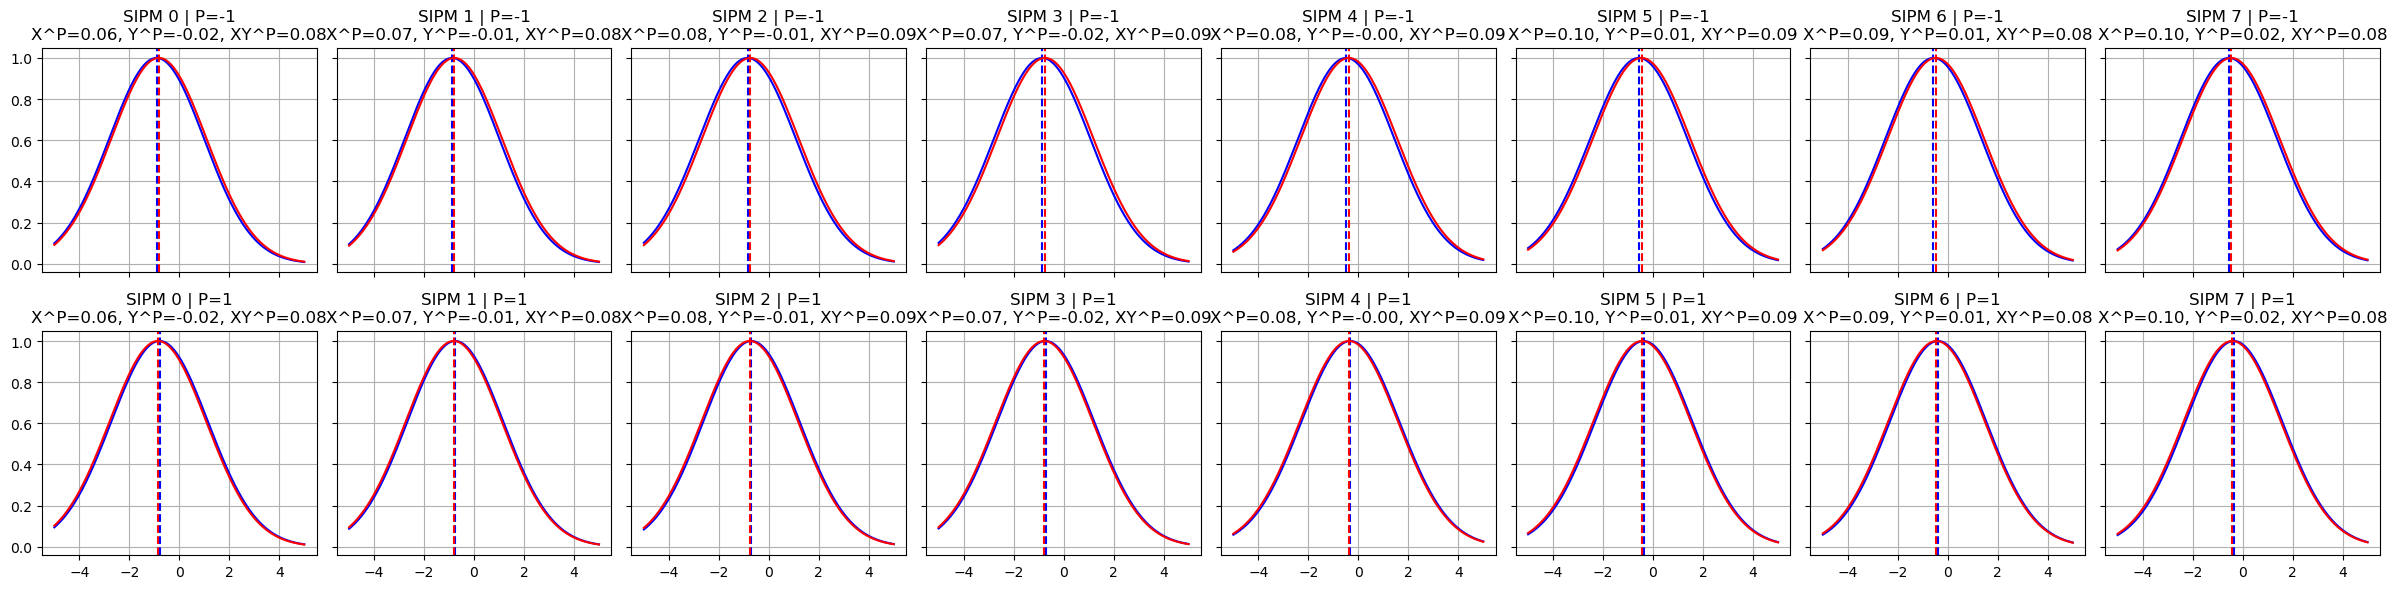

In [ ]:
fig = plot_gaussian_summary(fitted_df, parity_transform)
fig.savefig(os.path.join(a.run_folder, "doppler_gaussian_summary"+str(run).zfill(4) + "."+ str(sequence).zfill(4)+".png"), dpi=300, bbox_inches='tight')